# Old EVA relasese


Things to find out:

- [x] Number of evidence
- [x] Number of associatin
- [x] Number of positive controls recovered
- [X] ROC of scores.

In [10]:
import json
import gzip
import pandas as pd
import requests


# Parsing EVA data:
eva_file = '/Users/dsuveges/project/evidences/EVA/cttv012-01-09-2020_AD_manually_corrected.json.gz'

parsed_data = []

with gzip.open(eva_file, 'r') as f:
    for line in f:
        data = json.loads(line)
        evidence = {
            'type': data['type'],
            'target': data['unique_association_fields']['gene'],
            'disease': data['unique_association_fields']['phenotype'].split('/')[-1],
            'rsid': data['unique_association_fields']['variant_id'],
            'clinvar_acces': data['unique_association_fields']['clinvarAccession'],   
        }
        
        if data['type'] == 'genetic_association':
            evidence.update({
                'score': data['evidence']['variant2disease']['resource_score']['value'],
                'clinical_significance': data['evidence']['variant2disease']['clinical_significance'],
                'so_code':  data['evidence']['gene2variant']['functional_consequence'].split('/')[-1],
            })
            
        elif data['type'] == 'somatic_mutation':
            evidence.update({
                'score': data['evidence']['resource_score']['value'],
                'clinical_significance': data['evidence']['clinical_significance'],
                'so_code':  data['evidence']['known_mutations'][0]['functional_consequence'].split('/')[-1],
            })
        parsed_data.append(evidence)

eva_df = pd.DataFrame(parsed_data)
print(eva_df.head())
print(eva_df.type.value_counts())


                  type           target          disease         rsid  \
0  genetic_association  ENSG00000151150  Orphanet_356996  rs730882195   
1  genetic_association  ENSG00000046604      EFO_0000318  rs794728100   
2  genetic_association  ENSG00000055118      EFO_0004269  rs794728490   
3  genetic_association  ENSG00000008086      EFO_0003756  rs202153551   
4  genetic_association  ENSG00000198947      EFO_0003756  rs754765424   

  clinvar_acces         score clinical_significance     so_code  
0  RCV000162096  1.000000e-07     Likely pathogenic  SO_0001583  
1  RCV000181253  1.000000e-07            Pathogenic  SO_0001589  
2  RCV000182041  1.000000e-07     Likely pathogenic  SO_0001583  
3  RCV000754670  1.000000e-07     Likely pathogenic  SO_0001587  
4  RCV000754679  1.000000e-07     Likely pathogenic  SO_0001583  
genetic_association    107847
somatic_mutation         8176
Name: type, dtype: int64


In [11]:
for t, group in eva_df.groupby('type'):
    print(f'Assoc count in {t}: {len(group[["target","disease"]].drop_duplicates())}')
    


Assoc count in genetic_association: 11510
Assoc count in somatic_mutation: 1035


## Adding positive controls:

In [12]:
pharma_project_file = '/Users/dsuveges/project/issue-1166_benchmarking_clingen_evidences/abbvie_pharmaprojects_2018_mapped.csv'

# Reading pharmaproject file as dataframe:
pharma_df = pd.read_csv(pharma_project_file)

# Renaming columns for easy handling:
pharma_df.rename(columns={
    'ensembl_id': 'target',
    'id': 'disease',
    'lApprovedUS.EU': 'approved'
}, inplace=True)

print(f'Number of entries in pharmaproject: {len(pharma_df)}')
print(f'Number of disease/target associations pair: {len(pharma_df[["target","disease"]].drop_duplicates())}')
print(pharma_df.head())




Number of entries in pharmaproject: 22947
Number of disease/target associations pair: 22947
            target  approved      disease
0  ENSG00000119535     False  EFO_1001255
1  ENSG00000151617     False  EFO_1000014
2  ENSG00000012779     False  EFO_0003894
3  ENSG00000026508     False  EFO_0003894
4  ENSG00000057252     False  EFO_0003894


In [16]:
literature_df = pd.read_parquet('/Users/dsuveges/project/evidences/20.06_evidence_data.filtered.parquet')
literature_df.rename(columns={
    'efo_code': 'disease',
    'gene_id': 'target'
}, inplace=True)

# Applying score threshold:
literature_df = literature_df.loc[literature_df.assoc_score >= 0.6]

print(f'rows: {len(literature_df)}')
print(f'unique associations: {len(literature_df[["disease","target"]].drop_duplicates())}')


summed_data = []

for (target, disease), group in literature_df.groupby(['target', 'disease']):
    summed_data.append({
        'target': target,
        'disease': disease,
    }) 

literature_assoc = pd.DataFrame(summed_data)

print(f'rows: {len(literature_assoc)}')
print(f'unique associations: {len(literature_assoc[["disease","target"]].drop_duplicates())}')


rows: 32570
unique associations: 20289
rows: 20289
unique associations: 20289


In [23]:
poscon = (
    pharma_df
    .merge(literature_assoc, on=['target','disease'], how='outer', indicator=True)
    .rename(columns={'_merge':'poscon_source'})
)

poscon.poscon_source = (
    poscon
    .poscon_source
    .apply(lambda x: 'pharma_project' if x == 'left_only' else 'literature' if x == 'right_only' else 'pharma_project+literature')
)

print(poscon.poscon_source.value_counts())

poscon.to_csv('/Users/dsuveges/project/evidences/positive_controls.tsv.gz', sep='\t', index=False, compression='infer')


pharma_project               21633
literature                   18975
pharma_project+literature     1314
Name: poscon_source, dtype: int64


In [22]:
print(len(poscon[['target', 'disease']]))
print(len(poscon[['target', 'disease']].drop_duplicates()))

41922
41922


### Merging EVA with positive controls:

In [25]:
eva_merged = eva_df.merge(poscon, on=['target','disease'], how='left')
print(len(eva_merged.loc[eva_merged.poscon_source.notna()]))
print(len(eva_merged.loc[eva_merged.poscon_source.notna(),['target','disease']].drop_duplicates()))




9196
416


In [27]:
eva_merged.clinical_significance.value_counts()

Pathogenic           79473
Likely pathogenic    35959
drug response          277
association            172
Affects                112
protective              30
Name: clinical_significance, dtype: int64

# Let's see how the score performs 

In [29]:
eva_df.columns

Index(['type', 'target', 'disease', 'rsid', 'clinvar_acces', 'score',
       'clinical_significance', 'so_code'],
      dtype='object')

In [38]:
import requests

def so_lookup(so_term):
    '''
    Function to do the OLS lookup, returns with the label.
    '''
    
    url = f'https://www.ebi.ac.uk/ols/api/terms?short_form={so_term}'
    r = requests.get(url)
    data = r.json()

    return data['_embedded']['terms'][0]['label']
    
# Generating a lookup dictionary:
so_lookup_table = {x:so_lookup(x) for x in eva_df.so_code.unique()}

# Adding consequence label:
eva_merged['consequence'] = eva_merged.so_code.map(so_lookup_table)
eva_merged.head()

,type,target,disease,rsid,clinvar_acces,score,clinical_significance,so_code,approved,poscon_source,consequence
0,genetic_association,ENSG00000151150,Orphanet_356996,rs730882195,RCV000162096,1.000000e-07,Likely pathogenic,SO_0001583,NaN,NaN,missense_variant
1,genetic_association,ENSG00000046604,EFO_0000318,rs794728100,RCV000181253,1.000000e-07,Pathogenic,SO_0001589,NaN,NaN,frameshift_variant
2,genetic_association,ENSG00000055118,EFO_0004269,rs794728490,RCV000182041,1.000000e-07,Likely pathogenic,SO_0001583,True,pharma_project,missense_variant
3,genetic_association,ENSG00000008086,EFO_0003756,rs202153551,RCV000754670,1.000000e-07,Likely pathogenic,SO_0001587,NaN,NaN,stop_gained
4,genetic_association,ENSG00000198947,EFO_0003756,rs754765424,RCV000754679,1.000000e-07,Likely pathogenic,SO_0001583,NaN,NaN,missense_variant


In [39]:
# 
eva_consequences_order_map = {
    'downstream_gene_variant': 0.6,
    'upstream_gene_variant': 0.6,
    'intron_variant': 0.65,
    'non_coding_transcript_exon_variant': 0.65,
    '3_prime_UTR_variant': 0.65,
    '5_prime_UTR_variant': 0.65,
    'mature_miRNA_variant': 0.65,
    'synonymous_variant': 0.65,
    'stop_retained_variant': 0.65,    
    
    'coding_sequence_variant': 0.95,
    'incomplete_terminal_codon_variant': 0.9,
    'splice_region_variant': 0.95,
    'protein_altering_variant': 0.7,
    'missense_variant': 0.7,
    'inframe_deletion': 0.7,
    'inframe_insertion': 0.7,
    
    'start_lost': 0.95,
    'stop_lost': 0.9,
    'frameshift_variant': 0.95,
    'stop_gained': 0.95,
    'splice_donor_variant': 0.95,
    'splice_acceptor_variant': 0.95,
    'trinucleotide_repeat_expansion': 1,
    'short_tandem_repeat_expansion': 1,
    'transcript_ablation': 1
}

eva_merged['consequence_score'] = eva_merged.consequence.map(eva_consequences_order_map)
eva_merged.head()

,type,target,disease,rsid,clinvar_acces,score,clinical_significance,so_code,approved,poscon_source,consequence,consequence_score
0,genetic_association,ENSG00000151150,Orphanet_356996,rs730882195,RCV000162096,1.000000e-07,Likely pathogenic,SO_0001583,NaN,NaN,missense_variant,0.70
1,genetic_association,ENSG00000046604,EFO_0000318,rs794728100,RCV000181253,1.000000e-07,Pathogenic,SO_0001589,NaN,NaN,frameshift_variant,0.95
2,genetic_association,ENSG00000055118,EFO_0004269,rs794728490,RCV000182041,1.000000e-07,Likely pathogenic,SO_0001583,True,pharma_project,missense_variant,0.70
3,genetic_association,ENSG00000008086,EFO_0003756,rs202153551,RCV000754670,1.000000e-07,Likely pathogenic,SO_0001587,NaN,NaN,stop_gained,0.95
4,genetic_association,ENSG00000198947,EFO_0003756,rs754765424,RCV000754679,1.000000e-07,Likely pathogenic,SO_0001583,NaN,NaN,missense_variant,0.70


In [47]:
import pandas as pd
import numpy as np
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
import gzip 
import tqdm
import requests

def harmonic_sum(data, scale_factor=1, cap=None):
    """
    Returns an harmonic sum for the data passed
    Args:
        data (list): list of floats to compute the harmonic sum from
        scale_factor (float): a scaling factor to multiply to each datapoint. Defaults to 1
        cap (float): if not None, never return an harmonic sum higher than the cap value.
    Returns:
        harmonic_sum (float): the harmonic sum of the data passed
    """
    
    if isinstance(data, pd.Series):
        data = data.tolist()

    data.sort(reverse=True)
    harmonic_sum = sum(s / ((i+1) ** scale_factor) for i, s in enumerate(data))
    
    # Applying cap:
    if cap is not None and harmonic_sum > cap:
        return cap
      
    return harmonic_sum


def add_missing_efo(efo_ids):
    missing_efo_map = {}
    for efo_id in efo_ids:
        url = f'https://www.ebi.ac.uk/ols/api/terms?short_form={efo_id}'
        r = requests.get(url)
        data = r.json()

        missing_efo_map[efo_id] = data['_embedded']['terms'][0]['label']

    return missing_efo_map
        

def add_missing_genes(genes):
    missing_gene_map = {}
    for ensembl_id in genes:
        r = requests.get(f'http://rest.ensembl.org/lookup/id/{ensembl_id}?content-type=application/json;expand=0')
        missing_gene_map[ensembl_id] = r.json()['display_name']
        
    return missing_gene_map


def so_lookup(so_term):
    '''
    Function to do the OLS lookup, returns with the label.
    '''
    
    url = f'https://www.ebi.ac.uk/ols/api/terms?short_form={so_term}'
    r = requests.get(url)
    data = r.json()

    return data['_embedded']['terms'][0]['label']
    

def read_eva_evidences(source_file):
    
    parsed_data = []

    with gzip.open(source_file) as f:
        for line in f:
            data = json.loads(line)
            evidence = {
                'type': data['type'],
                'target': data['unique_association_fields']['gene'],
                'disease': data['unique_association_fields']['phenotype'].split('/')[-1],
                'rsid': data['unique_association_fields']['variant_id'],
                'clinvar_acces': data['unique_association_fields']['clinvarAccession'],   
            }

            if data['type'] == 'genetic_association':
                evidence.update({
                    'score': data['evidence']['variant2disease']['resource_score']['value'],
                    'star': data['evidence']['variant2disease']['clinvar_rating']['star_rating'],
                    'review_status': data['evidence']['variant2disease']['clinvar_rating']['review_status'],
                    'clinical_significance': data['evidence']['variant2disease']['clinical_significance'],
                    'so_code':  data['evidence']['gene2variant']['functional_consequence'].split('/')[-1],
                })

            elif data['type'] == 'somatic_mutation':
                evidence.update({
                    'score': data['evidence']['resource_score']['value'],
                    'star': data['evidence']['clinvar_rating']['star_rating'],
                    'review_status': data['evidence']['clinvar_rating']['review_status'],
                    'clinical_significance': data['evidence']['clinical_significance'],
                    'so_code': data['evidence']['known_mutations'][0]['functional_consequence'].split('/')[-1],
                })
            parsed_data.append(evidence)

    return pd.DataFrame(parsed_data)


##
## Function to get evidence score based on a set of weights:
##
def calculate_evidence_score(row, weights):
    """
    Based on the weights of the given clumns the evidence sore is calcualted as follows:
    sum[1->i](wi*di)
    """
    
    # Generate evidence score:
    score = 0
    for col in weights.index:
        score += row[col] * weights[col]

    return score

##
## calculating auc and enrichment for plotting:
##
def calculate_auc(association_score):
    
    # calculate auc:
    fpr, tp, thresholds = roc_curve(association_score.poscon, association_score.association_score)
    auc = roc_auc_score(association_score.poscon, association_score.association_score)

    # Calculate enrichment:
    top_n = len(association_score.loc[association_score.poscon])

    recovery = (
        association_score
        .sort_values('association_score', ascending=False)
        .head(top_n)
        .query('poscon == True')
        .association_score
        .size
    )

    enrichment = len(association_score) * recovery / top_n ** 2

    return {
        'fpr': fpr,
        'tpr': tp,
        'auc': auc,
        'recovery': recovery,
        'enrichment': enrichment
    }

##
## Plot ROC curve for many tests
##
def plot_auc_all(results):

    # Draw baseline:
    pyplot.plot([x/100 for x in range(1,100,1)], [x/100 for x in range(1,100,1)], linestyle='--', label=f'baseline')

    # Calculated curves:
    for label, data in results.items():
        pyplot.plot(data['fpr'], data['tpr'], marker='.', markersize = 1, label=f'{label} (auc:{data["auc"]:.2}, enr:{data["enrichment"]:.2}x)') # variant count

    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')

    # Add legend:
    pyplot.legend(bbox_to_anchor=(1, 1))

##
## Running the classifier are calculate parameters:
##
def get_fit_parameters(df, columns):

    # Build classifier:
    if len(columns) > 1:
        rf = RandomForestClassifier(class_weight='balanced')
        rf.fit(df[columns],df.poscon)  

        # Extracting weight:
        print('Extract weights...')
        weight_series = pd.Series(rf.feature_importances_, index=columns)
        print(weight_series.sort_values())

        # Combining evidence score in to association score:
        association_score = (
            df
            .set_index(['disease', 'target'])
            .apply(calculate_evidence_score, args=(weight_series,), axis=1)
            .groupby(['target','disease'])
            .apply(harmonic_sum)
            .rename('association_score')
            .to_frame()
            .merge(df[['target','disease','poscon']].drop_duplicates(), on=['target','disease'], how='left')
        )
    else:
        association_score = (
            df
            .groupby(['target','disease'])
            [columns[0]]
            .apply(harmonic_sum)
            .rename('association_score')
            .to_frame()
            .merge(df[['target','disease','poscon']].drop_duplicates(), on=['target','disease'], how='left')
        )

    return calculate_auc(association_score)    



##
## Hot-one ecode set of columns
##
def hot1(df, columns, prefix):

    # Get unique clinical significance values:
    feature_df = df[['target','disease','poscon'] + columns].copy()

    # Generate dummy features from clinical significance values:
    feature_df = pd.get_dummies(feature_df, prefix=prefix, columns=columns)

    cols = [x for x in feature_df.columns if f'{prefix}_' in x]
    return  get_fit_parameters(feature_df, cols)

    # Generate dummy features from clinical significance values:
    clin_sig_split = pd.get_dummies(clin_sig_split, prefix='clin_sig', columns=['clinical_signif'])

    # Update dummy columns were more then one clinical significance value is available:
    for i, row in clin_sig_split.loc[clin_sig_split.clinical_significance.apply(lambda x: True if len(x)>1 else False)].iterrows():
        for sig_val in row['clinical_significance']:
            clin_sig_split.loc[i,f'clin_sig_{sig_val}'] = 1

In [45]:
eva_merged['poscon'] = eva_merged.poscon_source.apply(lambda x: True if isinstance(x, str) else False)
eva_merged.poscon.fillna(False, inplace=True)
eva_merged.head()

,type,target,disease,rsid,clinvar_acces,score,clinical_significance,so_code,approved,poscon_source,consequence,consequence_score,poscon
0,genetic_association,ENSG00000151150,Orphanet_356996,rs730882195,RCV000162096,1.000000e-07,Likely pathogenic,SO_0001583,NaN,NaN,missense_variant,0.70,False
1,genetic_association,ENSG00000046604,EFO_0000318,rs794728100,RCV000181253,1.000000e-07,Pathogenic,SO_0001589,NaN,NaN,frameshift_variant,0.95,False
2,genetic_association,ENSG00000055118,EFO_0004269,rs794728490,RCV000182041,1.000000e-07,Likely pathogenic,SO_0001583,True,pharma_project,missense_variant,0.70,True
3,genetic_association,ENSG00000008086,EFO_0003756,rs202153551,RCV000754670,1.000000e-07,Likely pathogenic,SO_0001587,NaN,NaN,stop_gained,0.95,False
4,genetic_association,ENSG00000198947,EFO_0003756,rs754765424,RCV000754679,1.000000e-07,Likely pathogenic,SO_0001583,NaN,NaN,missense_variant,0.70,False


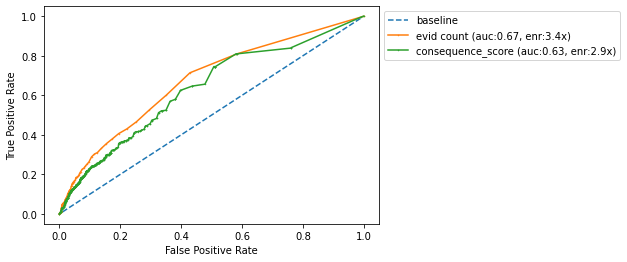

In [48]:
# hot1(db, columns, prefix)
results = {}

# baseline:
columns = ['baseline']
results['evid count'] = get_fit_parameters(eva_merged.assign(baseline=1),columns)

# review status - simple weighted:
results['consequence_score'] = get_fit_parameters(eva_merged, ['consequence_score'])
       
plot_auc_all(results)

In [49]:
pd.__version__

'1.1.0'